In [1]:
import limbo
from limbo.processing import CALGAIN
from limbo.database import HEADER, DATABASE_DIR
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import shutil
import time
from scipy.ndimage import maximum_filter1d, zoom
import glob

%matplotlib inline
# %matplotlib notebook

# %load_ext memory_profiler

In [2]:
# filename = os.environ['LIMBO_PROCFILE']
filename = '/home/obs/data/save/Spectra_20230613155353.dat'
INJECT_FRB = 0
NSIG = 5.5
MAX_DM = 500
MASK_DM = 300
EXCLUDE_S = float(os.environ.get('LIMBO_EXCLUDE_S', '0.05'))
REMOVE_DIR = os.environ.get('LIMBO_REMOVE_DIR', None)
SAVE_DIR = os.environ.get('LIMBO_SAVE_DIR', None)
VOLT_DIR = os.environ.get('LIMBO_VOLT_DIR', None)
VOLT_SAVE_DIR = os.environ.get('LIMBO_VOLT_SAVE_DIR', None)
CH0, CH1 = 398, 398+1024
UPDATE_DATABASE = os.environ.get('LIMBO_UPDATE_DATABASE', 'False')
                    
print('Processing:', filename)
print('INJECT_FRB:', INJECT_FRB)
print('NSIG:', NSIG)
print('MAX_DM:', MAX_DM)
print('MASK_DM:', MASK_DM)
print('EXCLUDE_S:', EXCLUDE_S)
print('REMOVE_DIR:', REMOVE_DIR)
print('SAVE_DIR:', SAVE_DIR)
print('VOLT_DIR:', VOLT_DIR)
print('VOLT_SAVE_DIR:', VOLT_SAVE_DIR)
print('UPDATE_DATABASE:', UPDATE_DATABASE)

Processing: /home/obs/data/save/Spectra_20230613155353.dat
INJECT_FRB: 0
NSIG: 5.5
MAX_DM: 500
MASK_DM: 300
EXCLUDE_S: 0.05
REMOVE_DIR: None
SAVE_DIR: None
VOLT_DIR: None
VOLT_SAVE_DIR: None
UPDATE_DATABASE: False


In [3]:
hdr, data = limbo.io.read_file(filename)
print('Observed:', time.ctime(hdr['Time']))
for k, v in hdr.items():
    print(f'    {k:15s}: {v}')
ker = int(np.around(EXCLUDE_S / hdr['inttime']))
print(f'ker={ker}')

Observed: Tue Jun 13 15:53:49 2023
    SWVer          : 0.0.4
    fpg            : limbo_500_m_2023-05-09_1203.fpg
    Time           : 1686671629.411203
    AccLen         : 128
    AdcCoarseGain  : 4
    FFTShift       : 2047
    DataSel        : 1
    Scaling        : 0
    Pol0EqCoeff    : 59904
    Pol1EqCoeff    : 59904
    SpecCoeff      : 4
    AdcDelay0      : 5
    AdcDelay1      : 5
    AdcDelay2      : 5
    AdcDelay3      : 5
    AdcDelay4      : 5
    AdcDelay5      : 5
    AdcDelay6      : 5
    AdcDelay7      : 5
    RF_Lo_Hz       : 1350000000
    Source         : sgr1935
    Target_RA_Deg  : 19h34m55.598s
    Target_DEC_Deg : +21d53m47.79s
    Pointing_AZ    : 284.34
    Pointing_EL    : 17.78
    Pointing_Updated: 1686671632.008841
    filename       : /home/obs/data/save/Spectra_20230613155353.dat
    sample_clock   : 500000000.0
    freqs          : [1.35000000e+09 1.35012207e+09 1.35024414e+09 ... 1.59963379e+09
 1.59975586e+09 1.59987793e+09]
    Time_created   :

In [4]:
class Summary:
    
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.dms = {
            (0  ,100): [],
            (100,200): [],
            (200,300): [],
            (300,400): [],
            (400,500): [],
            (500,1000): [],
            (1000,2000): [],
            (2000,3000): [],
            (3000,4000): [],
        }
        self.avg_spec = []
        self.gain_vs_t = []
    
    def add_summary(self, summary):
        dm_vs_t = summary['dmt']
        dms = summary['dms']
        for (lo, hi) in self.dms.keys():
            try:
                self.dms[lo, hi].append(np.max(dm_vs_t[:,np.logical_and(hi > dms, dms >= lo)], axis=1))
            except(ValueError):
                pass
    
    def get_summary(self):
        rv = {}
        for k, v in self.dms.items():
            try:
                rv[k] = np.concatenate(v)
            except(ValueError):
                pass
        return rv
    
    def get_events(self, ker, nsig, summary=None, in_keys=[(300,400)], out_keys=[(0,100),(100,200)],
                   verbose=True):
        if summary is None:
            summary = self.get_summary()
            
        events = {}
        for k, v in summary.items():
            if type(k) == str:
                continue
            avg = np.median(v)
            sig = np.median(np.abs(v - avg))
            zscore = (v - avg) / sig
            if verbose:
                print(f'DM={k}: avg={avg:7.2f} +/- {sig:7.2f}')
            events[k] = zscore
        events['out'] = np.array([events[k] for k in out_keys]).max(axis=0)
        events['in'] = np.array([events[k] for k in in_keys]).max(axis=0)
        events['thresh'] = np.ones_like(events['out']) * nsig
        events['interesting'] = (events['in'] > events['thresh'])
        return events

In [5]:
# Process the data
dts = hdr['times'] - hdr['times'][0]

if INJECT_FRB:
    sim_frb = limbo.sim.make_frb(hdr['times'], hdr['freqs'], DM=332,
                                 pulse_width=0.12e-3, pulse_amp=30, t0=hdr['times'][1000])
    sim_frb *= (limbo.processing.FMDL / limbo.processing.FMDL.max())
    data = data + sim_frb

dmt = limbo.processing.process_data(hdr, data, maxdm=MAX_DM, 
                                    inpaint=True, ch0=CH0, ch1=CH1)

summary = Summary()
summary.add_summary(dmt)
report = summary.get_summary()
events = summary.get_events(ker, NSIG, summary=report)
interesting = np.any(events['interesting'])

/home/obs/miniconda3/lib/python3.11/site-packages/limbo/processing.py:104: RuntimeWarning: invalid value encountered in divide
  fzsq = np.sum(full_mask * zsq, axis=0) / np.sum(full_mask, axis=0)


DM=(0, 100): avg=2370.20 +/-  581.53
DM=(100, 200): avg=2352.17 +/-  502.90
DM=(200, 300): avg=2317.96 +/-  438.07
DM=(300, 400): avg=2255.90 +/-  428.36
DM=(400, 500): avg=2262.90 +/-  410.51


In [6]:
### STAGE 1: Look for all events above threshold.
print(f"DMs: {dmt['dms'][0]} -- {dmt['dms'][-1]}")
for k, v in events.items():
    if k == 'interesting':
        print(f'{k}: {(v > 0).sum()} event(s)')
    elif type(k) is tuple:
        event_ts = (v > events['thresh'])
        nevents = event_ts.sum()
        print(f'{k}: {nevents} event(s)', end='')
        if nevents > 0:
            ki = np.searchsorted(dmt['dms'], k[0])
            kj = np.searchsorted(dmt['dms'], k[1])
            inds = np.argmax(dmt['dmt'][event_ts, ki:kj], axis=1)
            print(f', nsig_max={v[v > events["thresh"]].max():3.1f}, dms={dmt["dms"][ki:kj][inds]}')
        else:
            print()
print('\nAnything Interesting:', interesting)

DMs: 0.0 -- 499.51171875
(0, 100): 1166 event(s), nsig_max=221.9, dms=[17.578125  14.6484375 10.7421875 ...  6.8359375  3.90625    0.       ]
(100, 200): 828 event(s), nsig_max=173.5, dms=[141.6015625  138.671875   197.265625   199.21875    197.265625
 199.21875    199.21875    194.3359375  190.4296875  186.5234375
 181.640625   176.7578125  171.875      167.96875    163.0859375
 159.1796875  154.296875   149.4140625  145.5078125  140.625
 135.7421875  131.8359375  126.953125   123.046875   118.1640625
 113.28125    109.375      104.4921875  100.5859375  107.421875
 102.5390625  107.421875   102.5390625  199.21875    195.3125
 191.40625    186.5234375  182.6171875  177.734375   172.8515625
 168.9453125  164.0625     159.1796875  199.21875    196.2890625
 191.40625    187.5        182.6171875  178.7109375  173.828125
 169.921875   165.0390625  160.15625    155.2734375  150.390625
 146.484375   141.6015625  137.6953125  132.8125     128.90625
 124.0234375  120.1171875  115.234375   110.3

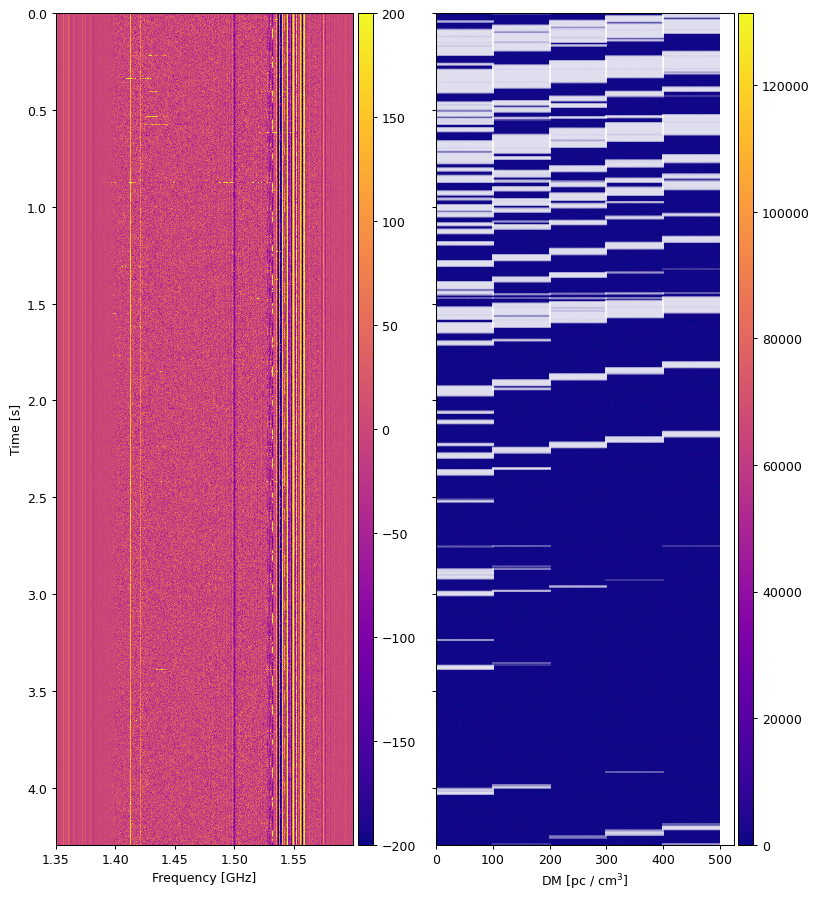

In [7]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)

scale = 200
im0 = axes[0].imshow(np.where(dmt['diff'] == 0, np.nan, dmt['diff']),
               extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
               cmap='plasma', vmax=scale, vmin=-scale, interpolation='nearest', aspect='auto')
im1 = axes[1].imshow(dmt['dmt'], cmap='plasma', vmin=0,
               extent=(dmt['dms'][0], dmt['dms'][-1], dts[-1], dts[0]),
               interpolation='nearest', aspect='auto')
for k, v in events.items():
    if type(k) is str:
        continue
    for t in dts[v > events['thresh']]:
        axes[1].plot(k, (t, t), 'w', alpha=0.2)
axes[0].set_xlabel('Frequency [GHz]')
axes[1].set_xlabel('DM [pc / cm$^3$]')
axes[0].set_ylabel('Time [s]')
cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im0, cax=cax)
cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im1, cax=cax)

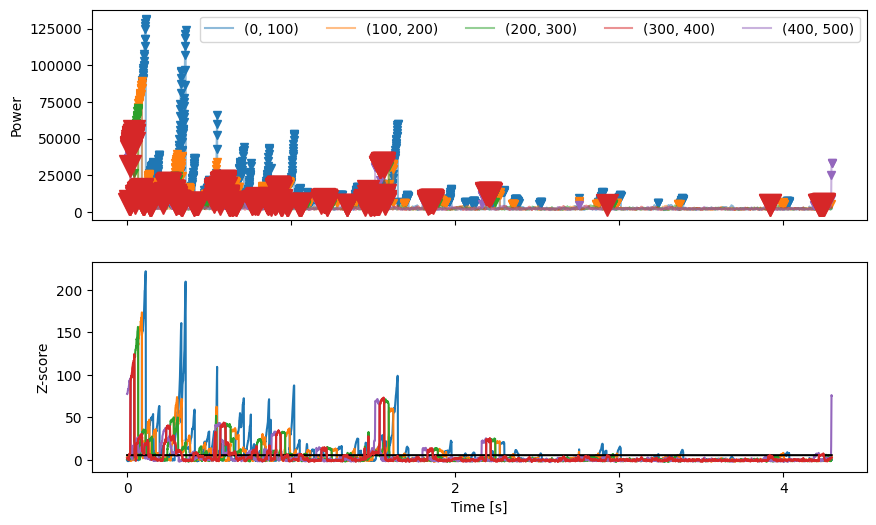

In [8]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
colors = {}
for k, v in events.items():
    if type(k) == str:
        continue
    line, = axes[0].plot(dts, report[k], label=k, alpha=0.5)
    colors[k] = line.get_color()
    axes[0].plot(dts[v > events['thresh']], report[k][v > events['thresh']], 'v', color=line.get_color())
    axes[1].plot(dts, v, color=colors[k])
    
k = (300, 400)
v = events[k]
axes[0].plot(dts[events['interesting'] & (v > events['thresh'])], 
             report[k][events['interesting'] & (v > events['thresh'])], 
             'v', color=colors[k], markersize=16)
axes[1].plot(dts, events['thresh'], 'k')
axes[1].plot(dts, events['in'], color=colors[k])
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel('Power')
axes[1].set_ylabel('Z-score')
_ = axes[0].legend(ncol=5)

In [9]:
### STAGE 2: For all 300-400 DM events de-disperse them to DM of SGR1935+2154. 
## Keep only those that can be de-dispersed to that DM.
if interesting:
    cal_data = dmt['diff'] * CALGAIN
    k = (300, 400)
    DM = 332.7
    resamp_factor = 4 # factor to over-sample by
    delays = limbo.sim.DM_delay(DM, hdr['freqs']).astype('float32')
    delays -= delays[-1]  # center lowest delay at t0
    profile = limbo.utils.dedisperse(cal_data, DM, hdr['freqs'], hdr['inttime'], resamp_factor)
    thresh_interp = zoom(events['thresh'], zoom=resamp_factor, 
                         mode='nearest', order=0) # over-sample events['thresh']

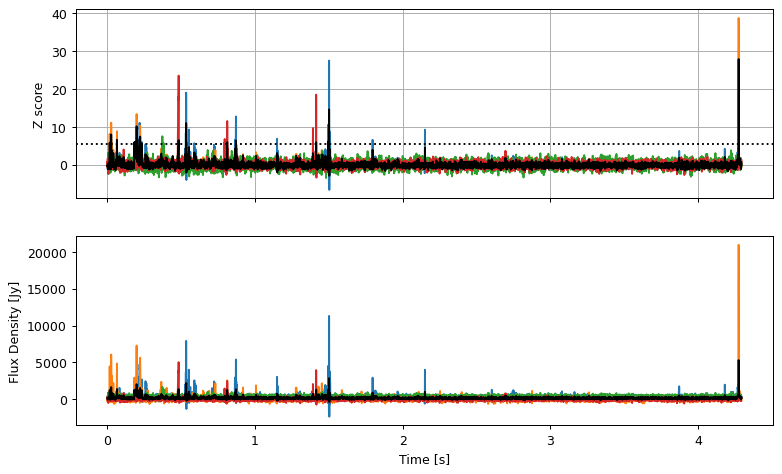

In [11]:
if interesting:
    _dts = np.linspace(hdr['times'][0], hdr['times'][-1], profile.shape[0], endpoint=False) # Unix time
    zeroed_dts = _dts - hdr['Time']
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=90)
    freq_binned_profile = np.mean(profile[:, CH0:CH1].reshape(profile.shape[0], -1, 256), axis=-1)
    avg_profile = np.mean(profile[:, CH0:CH1], axis=-1)
    zscore = (avg_profile - np.mean(avg_profile)) / np.std(avg_profile)
    axes[0].plot(zeroed_dts, (freq_binned_profile - np.mean(freq_binned_profile, axis=0, keepdims=True)) / np.std(freq_binned_profile, axis=0, keepdims=True))
    axes[0].plot(zeroed_dts, zscore, 'k')
    axes[0].axhline(NSIG, color='k', ls='dotted')
    axes[1].plot(zeroed_dts, freq_binned_profile)
    axes[1].plot(zeroed_dts, avg_profile, 'k')
    axes[1].set_xlabel('Time [s]')
    axes[0].set_ylabel('Z score')
    axes[0].grid()
    axes[1].set_ylabel('Flux Density [Jy]')

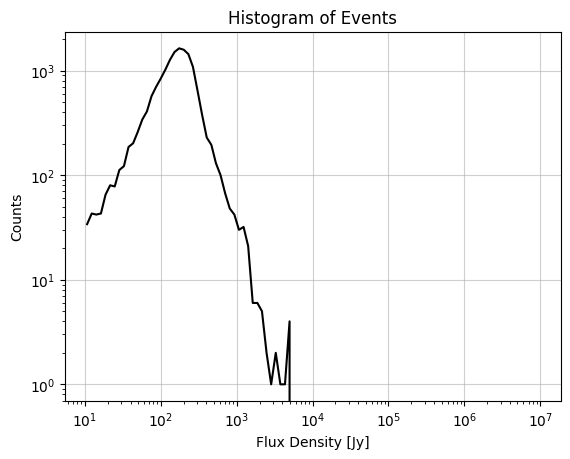

In [12]:
if interesting:
    plt.figure()
    _bins = np.linspace(1, 7, 100)
    hist, bins_edges = np.histogram(np.log10(avg_profile[avg_profile>0]), bins=_bins)
    bins = 0.5*(bins_edges[1:] + bins_edges[:-1])
    plt.loglog(10**bins, hist, color='k')
    plt.xlabel('Flux Density [Jy]')
    plt.ylabel('Counts')
    plt.title('Histogram of Events')
    plt.grid(alpha=0.6)
    plt.show()
else:
    hist, bins = np.nan, np.nan
    zmax = np.nan
    tind_events = np.array([])
    

In [13]:
### STAGE 3: Of the surviving events, determine if their de-dispersed z-scores are above a threshold.
save_file = False
if interesting:
    tind_events = np.where((zscore > thresh_interp))[0]
    if tind_events.size > 0:
        zmax = np.max(zscore[tind_events])
        print(f'De-dispersed Z-score: {zmax:4.1f}')
        save_file = True
        
if not save_file:
    zmax = np.nan
        
print('Save file:', save_file)

De-dispersed Z-score: 27.9
Save file: True


In [14]:
if save_file:
    print(f'Number of events: {tind_events.size}')
    print(f'Time of events: {zeroed_dts[tind_events]}')
    print(f'Max measured flux: {np.max(avg_profile)} Jy')

Number of events: 72
Time of events: [0.0157249  0.0259459  0.02620792 0.02647018 0.02673221 0.06447172
 0.06473374 0.06499577 0.06525803 0.18188357 0.1821456  0.18817353
 0.18843555 0.18869758 0.19734621 0.19760823 0.19787049 0.19813251
 0.19839454 0.19865656 0.19891882 0.21805048 0.21831274 0.21857476
 0.21883678 0.21909881 0.22067142 0.22093344 0.22119546 0.22145748
 0.22171974 0.22198176 0.22224379 0.22250581 0.22276807 0.22303009
 0.22329211 0.22355413 0.23325109 0.48222709 0.48248935 0.48275137
 0.48301339 0.53333282 0.53359485 0.53385687 0.53411913 0.53438115
 0.81166172 0.81192374 0.87036777 0.87062979 1.41418362 1.49700093
 1.49726295 1.50119424 1.50145626 1.50171828 1.50198054 1.50224257
 4.27321434 4.27347636 4.27373838 4.27400064 4.27426267 4.27452469
 4.27478671 4.27504873 4.27531099 4.27557302 4.27583504 4.27609706]
Max measured flux: 5303.51220703125 Jy


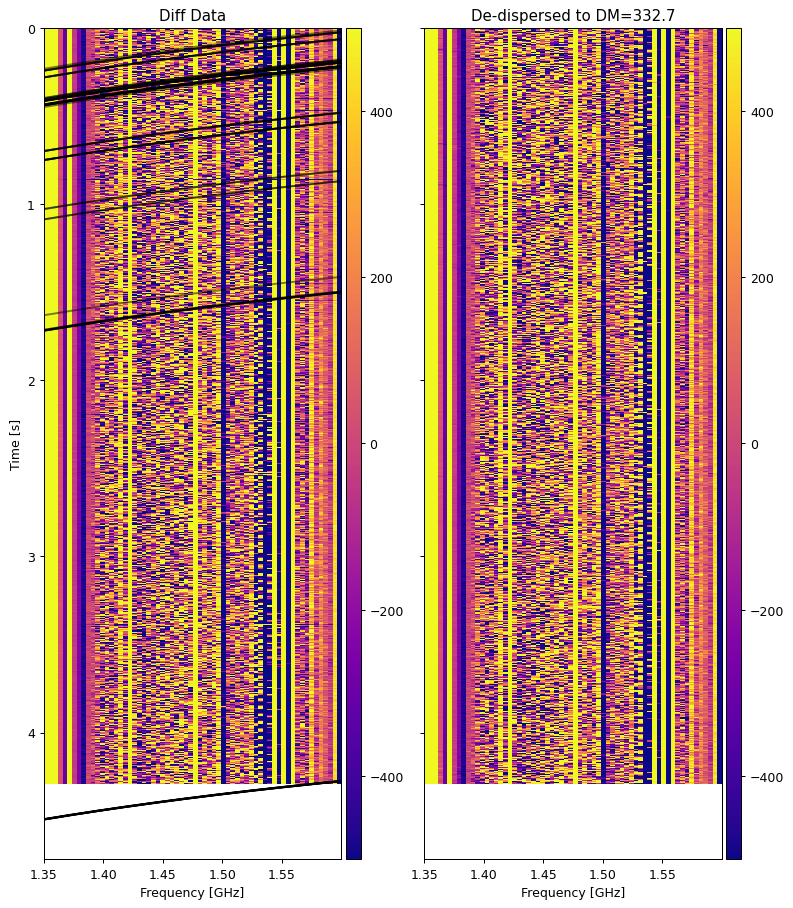

In [15]:
if save_file:
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)
#     scale = 5000
    min_scale, max_scale = -500, 500
    cd = cal_data.copy()
    cd.shape = (cd.shape[0], -1, 32)
    pd = profile[::resamp_factor].copy() # return to raw sampling
    pd.shape = (pd.shape[0], -1, 32)
    cd = np.mean(cd, axis=-1)
    pd = np.mean(pd, axis=-1)
    im0 = axes[0].imshow(cd, extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
                   cmap='plasma', vmax=max_scale, vmin=min_scale, interpolation='nearest', aspect='auto')
    im1 = axes[1].imshow(pd, extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
                   cmap='plasma', vmax=max_scale, vmin=min_scale, interpolation='nearest', aspect='auto')
    for event in tind_events:
        t = zeroed_dts[event]
        axes[0].plot(hdr['freqs'] / 1e9, t + delays, 'k', alpha=0.5)
    axes[0].set_xlabel('Frequency [GHz]')
    axes[1].set_xlabel('Frequency [GHz]')
    axes[0].set_title(f'Diff Data')
    axes[1].set_title(f'De-dispersed to DM={DM:3.1f}')
    axes[0].set_ylabel('Time [s]')
    cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im0, cax=cax)
    cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im1, cax=cax)

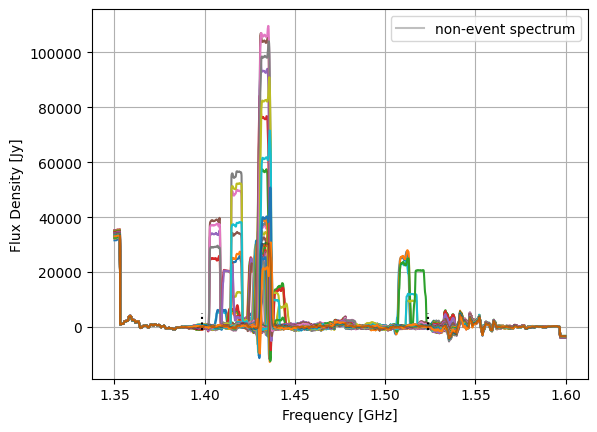

In [16]:
if save_file:
    KER = 50
    plt.figure()
    for i in tind_events:
        plt.plot(hdr['freqs'] / 1e9, np.convolve(profile[i], np.ones(KER)/KER, mode='same'))
    plt.plot(hdr['freqs'] / 1e9, np.convolve(profile[100], np.ones(KER)/KER, mode='same'), alpha=0.25, color='k', label='non-event spectrum')
    plt.vlines([hdr['freqs'][CH0] / 1e9, hdr['freqs'][CH1] / 1e9], -1e3, 5e3, color='k', linestyles='dotted')
    plt.grid()
    plt.legend()
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Flux Density [Jy]')
    plt.show()

In [17]:
if save_file:
    if SAVE_DIR != None:
        outfile = os.path.join(SAVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
        os.rename(filename, outfile)
    if VOLT_SAVE_DIR != None and VOLT_DIR != None:
        volt_files = sorted(glob.glob(os.path.join(VOLT_DIR, '*.dat')))
        start_times = np.array([limbo.io.read_start_time(f) for f in volt_files]) - hdr['Time']
        save_vfiles = [f for f, t in zip(volt_files, start_times) if t > -1 and t < 5]
        for vfile in save_vfiles:
            outfile = os.path.join(VOLT_SAVE_DIR, os.path.basename(vfile))
            print(f'Moving {vfile} -> {outfile}')
#             os.rename(vfile, outfile)
            shutil.copy(vfile, outfile)
            os.remove(vfile)
else:
    if REMOVE_DIR != None:
        outfile = os.path.join(REMOVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
#         os.rename(filename, outfile)
        shutil.copy(filename, outfile)
        os.remove(filename)
        # Voltage data deletes automatically when ring buffer fills + overwrites

In [23]:
if UPDATE_DATABASE:
    thresh_vals, thresh_cnts = np.unique(events['thresh'], return_counts=True)
    tmask_vals, tmask_cnts = np.unique(dmt['tmask'], return_counts=True)
    db = [filename, 
          hdr['Time'],
          hdr['Target_RA_Deg'],
          hdr['Target_DEC_Deg'], 
          tind_events.size,
          zmax,
          hist,
          bins,
          thresh_vals,
          thresh_cnts,
          tmask_vals,
          tmask_cnts]

    database = dict(zip(HEADER, db))
    np.savez(os.path.join(DATABASE_DIR, os.path.basename(filename)), **database)

In [24]:
# %memit